<h2>FreshCart Churn Prediction - Temel Model</h2>
 
<h4>
    <b>
        Zero2End Machine Learning Bootcamp - Bitirme Projesi
    </b>
</h4>

<h4>
    Notebook İçeriği
</h4>

<h5>
    <ol>
        <li>Veri Hazırlama ve Özellik Üretimi</li>
        <li>Eğitim-Test Bölünmesi</li>
        <li>Temel Model: Lojistik Regresyon</li>
        <li>Temel Model: Rastgele Orman (Random Forest)</li>
        <li>Model Değerlendirmesi</li>
        <li>Temel Sonuçlar ve Sonraki Adımlar</li>
    </ol>
</h5>

In [2]:
# Kütüphane importları
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)
import joblib

In [3]:
# Ayarlar
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [4]:
# src'yi path'e ekle
sys.path.append('../src')

In [5]:
# Proje-spesifik importlar
from config import RAW_DATA_DIR, PROCESSED_DATA_DIR, MODEL_DIR, RANDOM_STATE
from data.data_loader import InstacartDataLoader
from data.churn_labels import ChurnLabelCreator
from features.rfm_features import create_rfm_features_pipeline
from features.behavioral_features import create_behavioral_features_pipeline

print("Kütüphaneler başarıyla içe aktarıldı!")

Kütüphaneler başarıyla içe aktarıldı!


<h2>
    1-Veri Hazırlama ve Özellik Üretimi
</h2>

In [6]:
# Veri yükleme
print("Instacart verisi yükleniyor...")
loader = InstacartDataLoader(RAW_DATA_DIR)
data = loader.load_all_data()

orders_df = data['orders']
order_products = pd.concat([
    data['order_products_prior'],
    data['order_products_train']
], ignore_index=True)
products_df = data['products']

print(f"Veri yüklendi:")
print(f"Siparişler: {len(orders_df):,}")
print(f"Sipariş-Ürünler: {len(order_products):,}")
print(f"Ürünler: {len(products_df):,}")

INFO:data.data_loader:Instacart veri setleri yükleniyor...
INFO:data.data_loader:Yükleniyor: orders.csv...


Instacart verisi yükleniyor...


INFO:data.data_loader:Yüklendi orders: (3421083, 7)
INFO:data.data_loader:Yükleniyor: order_products__prior.csv...
INFO:data.data_loader:Yüklendi order_products_prior: (32434489, 4)
INFO:data.data_loader:Yükleniyor: order_products__train.csv...
INFO:data.data_loader:Yüklendi order_products_train: (1384617, 4)
INFO:data.data_loader:Yükleniyor: products.csv...
INFO:data.data_loader:Yüklendi products: (49688, 4)
INFO:data.data_loader:Yükleniyor: aisles.csv...
INFO:data.data_loader:Yüklendi aisles: (134, 2)
INFO:data.data_loader:Yükleniyor: departments.csv...
INFO:data.data_loader:Yüklendi departments: (21, 2)
INFO:data.data_loader:Tüm veri setleri başarıyla yüklendi!

INFO:data.data_loader:================================================================================
INFO:data.data_loader:VERİ ÖZETİ
INFO:data.data_loader:================================================================================
INFO:data.data_loader:orders                   :  3,421,083 satır x   7 sütun
INFO:data

Veri yüklendi:
Siparişler: 3,421,083
Sipariş-Ürünler: 33,819,106
Ürünler: 49,688


In [7]:
# --- VERİ BÖLME VE ETİKETLEME ---

print("\nVeriyi Geçmiş (Özellikler) ve Gelecek (Hedef) olarak bölüyoruz...")

# 1. Her kullanıcı için SON siparişi belirle (Bu bizim HEDEF verimiz)
last_orders = orders_df.groupby('user_id').tail(1)

# 2. Kalan tüm siparişler GEÇMİŞ veridir (Özellikler buradan türetilecektir)
orders_history = orders_df.drop(last_orders.index)

# 3. Ürün detaylarını sadece geçmiş siparişleri içerecek şekilde filtrele
# (Gelecekteki sepeti bilmek veri sızıntısı olur)
order_products_history = order_products[order_products['order_id'].isin(orders_history['order_id'])]

print(f"Toplam Siparişler: {len(orders_df):,}")
print(f"Geçmiş Siparişler (Özellik Kaynağı): {len(orders_history):,}")
print(f"Hedef Siparişler (Etiket Kaynağı): {len(last_orders):,}")


Veriyi Geçmiş (Özellikler) ve Gelecek (Hedef) olarak bölüyoruz...
Toplam Siparişler: 3,421,083
Geçmiş Siparişler (Özellik Kaynağı): 3,214,874
Hedef Siparişler (Etiket Kaynağı): 206,209


In [9]:
# --- HEDEF DEĞİŞKEN (ETİKET) OLUŞTURMA ---

print("\nHedef Siparişlerden etiketler oluşturuluyor...")

# Instacart verisinde tarih yok, sadece 'days_since_prior_order' var.
# Son sipariş önceki siparişten 30 gün (veya daha fazla) sonra verilmişse,
# bu müşteri o aralıkta "Churn" durumuna düşmüştür.

labels_df = last_orders[['user_id', 'days_since_prior_order']].copy()

# Churn Tanımı: 30+ gündür sipariş vermeyenler (1), diğerleri (0)
labels_df['is_churn'] = (labels_df['days_since_prior_order'] >= 30).astype(int)

print(f"Churn Etiketleri Oluşturuldu:")
print(f"Toplam kullanıcı: {len(labels_df):,}")
print(f"Churn Oranı: {labels_df['is_churn'].mean():.2%}")
print(labels_df['is_churn'].value_counts())


Hedef Siparişlerden etiketler oluşturuluyor...
Churn Etiketleri Oluşturuldu:
Toplam kullanıcı: 206,209
Churn Oranı: 30.64%
is_churn
0    143023
1     63186
Name: count, dtype: int64


In [10]:
# --- ÖZELLİK MÜHENDİSLİĞİ ---

# 'features/rfm_features.py' ve 'features/behavioral_features.py' dosyalarındaki sınıfları kullanacağız.

from features.rfm_features import RFMFeatureEngineer
from features.behavioral_features import BehavioralFeatureEngineer

print("\nGEÇMİŞ verisinden Özellikler Oluşturuluyor (Sızıntı Yok)...")

# 1. RFM Özellikleri
rfm_engineer = RFMFeatureEngineer()
rfm_features = rfm_engineer.create_all_rfm_features(orders_history, order_products_history)

# 2. Davranışsal Özellikler
behavioral_engineer = BehavioralFeatureEngineer()
behavioral_features = behavioral_engineer.create_all_behavioral_features(
    orders_history, order_products_history, products_df
)

# 3. Tüm Özellikleri Birleştir
print("\nÖzellikler Birleştiriliyor...")
master_df = labels_df[['user_id', 'is_churn']].merge(rfm_features, on='user_id', how='left')
master_df = master_df.merge(behavioral_features, on='user_id', how='left')

# Eksik değerleri doldur (Yeni kullanıcılar, vb.)
master_df = master_df.fillna(0)

print(f"Son Veri Seti Boyutu: {master_df.shape}")
# Sızıntı kontrolü: 'days_since_last_order' özelliği ŞİMDİ son siparişten ÖNCEKİ siparişe göre hesaplanıyor.
# Böylece hedefi görmüyor!

INFO:features.rfm_features:RFM özellikleri oluşturuluyor...


INFO:features.rfm_features:Yenilik özellikleri oluşturuluyor...



GEÇMİŞ verisinden Özellikler Oluşturuluyor (Sızıntı Yok)...


INFO:features.rfm_features:Sıklık özellikleri oluşturuluyor...
INFO:features.rfm_features:Parasal özellikler oluşturuluyor (sepet büyüklüğünü vekil olarak kullanarak)...
INFO:features.rfm_features:14 adet RFM özelliği oluşturuldu
INFO:features.rfm_features:Özellikler: ['days_since_last_order', 'days_since_first_order', 'customer_age_days', 'avg_days_between_orders', 'total_orders', 'orders_per_day', 'order_regularity', 'std_days_between_orders', 'avg_basket_size', 'total_items_ordered', 'basket_size_std', 'basket_size_cv', 'avg_unique_products_per_order', 'total_unique_products_ordered']
INFO:features.behavioral_features:Davranışsal özellikler oluşturuluyor...
INFO:features.behavioral_features:Zaman bazlı özellikler oluşturuluyor...
INFO:features.behavioral_features:Tekrar sipariş davranışı özellikleri oluşturuluyor...
INFO:features.behavioral_features:Çeşitlilik özellikleri oluşturuluyor...
INFO:features.behavioral_features:22 adet davranışsal özellik oluşturuldu



Özellikler Birleştiriliyor...
Son Veri Seti Boyutu: (206209, 38)


In [11]:
# Örnek veriyi ve istatistikleri göster
print("\nÖrnek Veri:")
display(master_df.head(10))

print("\nÖzellik İstatistikleri:")
display(master_df.describe())


Örnek Veri:


,user_id,is_churn,days_since_last_order,days_since_first_order,customer_age_days,avg_days_between_orders,total_orders,orders_per_day,order_regularity,std_days_between_orders,avg_basket_size,total_items_ordered,basket_size_std,basket_size_cv,avg_unique_products_per_order,total_unique_products_ordered,avg_order_hour,std_order_hour,preferred_hour,avg_order_dow,std_order_dow,preferred_dow,weekend_order_ratio,night_order_ratio,morning_order_ratio,afternoon_order_ratio,overall_reorder_rate,total_reordered_items,reorder_rate_std,avg_reorder_rate_per_order,reorder_consistency_std,favorite_products_count,unique_products,unique_aisles,unique_departments,avg_products_per_order,product_diversity_score,exploration_rate
0,1,0,623,686,63,19.555556,10,0.156250,0.457084,9.395625,5.900000,59,1.523884,0.220853,5.900000,59,10.300000,3.591657,7,2.500000,1.269296,1,0.000000,0.000000,0.600000,0.400000,0.694915,41,0.464396,0.705833,0.317544,4.0,18,12,7,5.900000,0.300000,0.500000
1,2,1,595,686,91,15.230769,14,0.152174,0.607923,9.867065,13.928571,195,5.717238,0.382973,13.928571,195,10.571429,1.554858,10,2.142857,1.231456,1,0.071429,0.000000,0.857143,0.142857,0.476923,93,0.500753,0.447961,0.315789,9.0,102,33,13,13.928571,0.520408,0.661017
2,3,0,609,686,77,12.090909,12,0.153846,0.410592,5.375026,7.333333,88,2.103388,0.252407,7.333333,88,16.416667,1.443376,16,1.083333,1.311372,0,0.000000,0.000000,0.000000,0.750000,0.625000,55,0.486897,0.658817,0.333725,5.0,33,16,9,7.333333,0.370787,0.277778
3,4,1,658,686,28,13.750000,5,0.172414,0.644068,9.500000,3.600000,18,2.073644,0.450792,3.600000,18,12.600000,1.673320,11,4.800000,0.836660,4,0.600000,0.000000,0.400000,0.600000,0.055556,1,0.235702,0.028571,0.063888,0.0,17,14,9,3.600000,0.894737,1.000000
4,5,0,665,686,21,13.333333,4,0.181818,0.344155,4.932883,9.250000,37,3.095696,0.302019,9.250000,37,16.000000,2.828427,18,1.750000,1.500000,3,0.000000,0.000000,0.000000,0.500000,0.378378,14,0.491672,0.377778,0.277555,0.0,23,16,9,9.250000,0.605263,0.500000
5,6,0,672,686,14,9.000000,3,0.200000,0.424264,4.242641,4.666667,14,2.081666,0.367353,4.666667,14,17.333333,1.154701,18,3.666667,1.527525,2,0.333333,0.000000,0.000000,0.333333,0.142857,2,0.363137,0.095238,0.164957,0.0,12,8,5,4.666667,0.800000,1.000000
6,7,0,553,686,133,10.684211,20,0.149254,0.767122,8.963213,10.300000,206,5.894690,0.521654,10.300000,206,13.600000,3.830625,9,1.850000,1.871532,0,0.150000,0.050000,0.300000,0.450000,0.669903,138,0.471393,0.754255,0.323768,13.0,68,34,12,10.300000,0.328502,0.568627
7,8,0,672,686,14,30.000000,3,0.200000,0.000000,0.000000,16.333333,49,4.163332,0.240192,16.333333,49,2.666667,4.618802,0,4.000000,2.645751,1,0.666667,0.666667,0.333333,0.000000,0.265306,13,0.446071,0.305983,0.275224,0.0,36,16,6,16.333333,0.720000,0.615385
8,9,1,672,686,14,18.000000,3,0.200000,0.893188,16.970563,25.333333,76,12.662280,0.480846,25.333333,76,14.333333,2.516611,12,2.000000,2.645751,0,0.333333,0.000000,0.000000,1.000000,0.236842,18,0.427970,0.254545,0.221191,0.0,58,26,13,25.333333,0.753247,0.600000
9,10,1,658,686,28,19.750000,5,0.172414,0.402008,8.341663,28.600000,143,14.842507,0.501436,28.600000,143,16.600000,2.701851,15,3.600000,1.341641,3,0.400000,0.200000,0.000000,0.600000,0.342657,49,0.476266,0.325665,0.413018,0.0,94,26,9,28.600000,0.652778,0.566667



Özellik İstatistikleri:


,user_id,is_churn,days_since_last_order,days_since_first_order,customer_age_days,avg_days_between_orders,total_orders,orders_per_day,order_regularity,std_days_between_orders,avg_basket_size,total_items_ordered,basket_size_std,basket_size_cv,avg_unique_products_per_order,total_unique_products_ordered,avg_order_hour,std_order_hour,preferred_hour,avg_order_dow,std_order_dow,preferred_dow,weekend_order_ratio,night_order_ratio,morning_order_ratio,afternoon_order_ratio,overall_reorder_rate,total_reordered_items,reorder_rate_std,avg_reorder_rate_per_order,reorder_consistency_std,favorite_products_count,unique_products,unique_aisles,unique_departments,avg_products_per_order,product_diversity_score,exploration_rate
count,206209.000000,206209.000000,206209.000000,206209.0,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.00000,206209.000000,206209.000000,206209.000000,206209.000000
mean,103105.000000,0.306417,583.867431,686.0,102.132569,15.209435,15.590367,0.163196,0.514670,7.397716,9.951586,157.289396,4.266349,0.400273,9.951586,157.289396,13.586213,3.588411,12.181559,2.753258,1.880159,2.077121,0.263415,0.102728,0.311936,0.485198,0.432249,92.753158,0.444387,0.457151,0.284327,7.332595,64.536238,27.78370,10.827796,9.951586,0.553921,0.570311
std,59527.555167,0.461006,116.583415,0.0,116.583415,7.105277,16.654774,0.017149,0.242831,3.746804,5.863570,204.208233,2.675061,0.167088,5.863570,204.208233,2.110461,1.553595,3.976492,0.941419,0.614210,2.060036,0.201648,0.151382,0.232377,0.233656,0.212144,158.400413,0.084416,0.215915,0.098324,12.433628,56.592339,16.11153,3.791768,5.863570,0.202130,0.216801
min,1.000000,0.000000,0.000000,686.0,14.000000,0.000000,3.000000,0.144105,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.010417,0.000000
25%,51553.000000,0.000000,560.000000,686.0,28.000000,9.416667,5.000000,0.149606,0.375000,4.730999,5.740741,39.000000,2.345208,0.288525,5.740741,39.000000,12.222222,2.548067,9.000000,2.200000,1.527525,0.000000,0.125000,0.000000,0.142857,0.333333,0.267857,10.000000,0.423915,0.294452,0.230136,0.000000,25.000000,15.00000,8.000000,5.740741,0.400000,0.454545
50%,103105.000000,0.000000,630.000000,686.0,56.000000,14.500000,9.000000,0.157895,0.527588,7.767830,8.933333,83.000000,3.781534,0.383990,8.933333,83.000000,13.571429,3.438246,12.000000,2.750000,1.936492,1.000000,0.250000,0.019608,0.285714,0.500000,0.428571,33.000000,0.474743,0.463889,0.282146,2.000000,48.000000,25.00000,11.000000,8.933333,0.558824,0.588235
75%,154657.000000,1.000000,658.000000,686.0,126.000000,20.285714,19.000000,0.172414,0.663707,9.908470,13.000000,188.000000,5.609516,0.490988,13.000000,188.000000,15.000000,4.438066,15.000000,3.333333,2.274152,4.000000,0.366667,0.166667,0.454545,0.666667,0.595745,101.000000,0.496842,0.626410,0.340386,9.000000,86.000000,38.00000,14.000000,13.000000,0.714286,0.714286
max,206209.000000,1.000000,672.000000,686.0,686.000000,30.000000,99.000000,0.200000,2.282372,21.213203,70.250000,3725.000000,44.747439,1.728671,70.250000,3725.000000,23.000000,13.279056,23.000000,6.000000,3.464102,6.000000,1.000000,1.000000,1.000000,1.000000,0.989529,3275.000000,0.577350,0.989899,0.577350,184.000000,726.000000,102.00000,21.000000,70.250000,0.989130,1.000000


In [12]:
# X ve y'yi hazırla
X = master_df.drop(['user_id', 'is_churn'], axis=1)
y = master_df['is_churn']

feature_names = X.columns.tolist()

print(f"Veri Seti Hazırlandı:")
print(f"   Özellikler (X): {X.shape}")
print(f"   Etiketler (y): {y.shape}")
print(f"   Özellik Sayısı: {len(feature_names)}")

Veri Seti Hazırlandı:
   Özellikler (X): (206209, 36)
   Etiketler (y): (206209,)
   Özellik Sayısı: 36


<h2>
    2-Eğitim-Test Bölünmesi
</h2>

In [13]:
# Eğitim-test bölünmesi
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"\nEğitim-Test Bölünmesi:")
print(f"   Eğitim: {X_train.shape} - Churn oranı: {y_train.mean():.2%}")
print(f"   Test:  {X_test.shape} - Churn oranı: {y_test.mean():.2%}")


Eğitim-Test Bölünmesi:
   Eğitim: (164967, 36) - Churn oranı: 30.64%
   Test:  (41242, 36) - Churn oranı: 30.64%


In [14]:
# Özellikleri ölçekle
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Scaler'ı kaydet
joblib.dump(scaler, MODEL_DIR / 'baseline_scaler.pkl')
print("Scaler fit edildi ve kaydedildi")

Scaler fit edildi ve kaydedildi


<h2>
    3-Temel Model 1: Lojistik Regresyon
</h2>

In [15]:
print("\n" + "="*80)
print("TEMEL MODEL 1: LOJİSTİK REGRESYON")
print("="*80)

# Modeli eğit
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=RANDOM_STATE,
    class_weight='balanced'
)

lr_model.fit(X_train_scaled, y_train)

# Tahminler
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Metrikler
lr_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_lr),
    'precision': precision_score(y_test, y_pred_lr),
    'recall': recall_score(y_test, y_pred_lr),
    'f1': f1_score(y_test, y_pred_lr),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_lr)
}

print("\nLojistik Regresyon Sonuçları:")
print(f"   Doğruluk:  {lr_metrics['accuracy']:.4f}")
print(f"   Kesinlik: {lr_metrics['precision']:.4f}")
print(f"   Duyarlılık:    {lr_metrics['recall']:.4f}")
print(f"   F1-Skoru:  {lr_metrics['f1']:.4f}")
print(f"   ROC-AUC:   {lr_metrics['roc_auc']:.4f}")

print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred_lr, target_names=['Aktif', 'Churned']))

# Modeli kaydet
joblib.dump(lr_model, MODEL_DIR / 'baseline_logistic_regression.pkl')
print("\nLojistik Regresyon modeli kaydedildi")


TEMEL MODEL 1: LOJİSTİK REGRESYON

Lojistik Regresyon Sonuçları:
   Doğruluk:  0.6643
   Kesinlik: 0.4697
   Duyarlılık:    0.7397
   F1-Skoru:  0.5746
   ROC-AUC:   0.7475

Sınıflandırma Raporu:
              precision    recall  f1-score   support

       Aktif       0.85      0.63      0.72     28605
     Churned       0.47      0.74      0.57     12637

    accuracy                           0.66     41242
   macro avg       0.66      0.69      0.65     41242
weighted avg       0.73      0.66      0.68     41242


Lojistik Regresyon modeli kaydedildi


<h2>
    4-Temel Model 2: Rastgele Orman (Random Forest)
</h2>

In [17]:
print("\n" + "="*80)
print("TEMEL MODEL 2: RASTGELE ORMAN")
print("="*80)

# Modeli eğit
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=RANDOM_STATE,
    class_weight='balanced',
    n_jobs=-1
)

rf_model.fit(X_train, y_train)  # RF ölçeklendirme gerektirmez

# Tahminler
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Metrikler
rf_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'precision': precision_score(y_test, y_pred_rf),
    'recall': recall_score(y_test, y_pred_rf),
    'f1': f1_score(y_test, y_pred_rf),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_rf)
}

print("\nRandom Forest Sonuçları:")
print(f"   Doğruluk:  {rf_metrics['accuracy']:.4f}")
print(f"   Kesinlik: {rf_metrics['precision']:.4f}")
print(f"   Duyarlılık: {rf_metrics['recall']:.4f}")
print(f"   F1-Skoru: {rf_metrics['f1']:.4f}")
print(f"   ROC-AUC: {rf_metrics['roc_auc']:.4f}")

print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred_rf, target_names=['Aktif', 'Churned']))

# Modeli kaydet
joblib.dump(rf_model, MODEL_DIR / 'baseline_random_forest.pkl')
print("\nRandom Forest modeli kaydedildi")


TEMEL MODEL 2: RASTGELE ORMAN

Random Forest Sonuçları:
   Doğruluk:  0.6627
   Kesinlik: 0.4690
   Duyarlılık: 0.7639
   F1-Skoru: 0.5812
   ROC-AUC: 0.7536

Sınıflandırma Raporu:
              precision    recall  f1-score   support

       Aktif       0.86      0.62      0.72     28605
     Churned       0.47      0.76      0.58     12637

    accuracy                           0.66     41242
   macro avg       0.66      0.69      0.65     41242
weighted avg       0.74      0.66      0.68     41242


Random Forest modeli kaydedildi


<h2>
    5-Model Değerlendirme & Görselleştirme
</h2>

In [18]:
# Karşılaştırma dataframe'i oluştur
comparison_df = pd.DataFrame({
    'Model': ['Lojistik Regresyon', 'Random Forest'],
    'Doğruluk': [lr_metrics['accuracy'], rf_metrics['accuracy']],
    'Kesinlik': [lr_metrics['precision'], rf_metrics['precision']],
    'Duyarlılık': [lr_metrics['recall'], rf_metrics['recall']],
    'F1-Skoru': [lr_metrics['f1'], rf_metrics['f1']],
    'ROC-AUC': [lr_metrics['roc_auc'], rf_metrics['roc_auc']]
})

print("\n" + "="*80)
print("TEMEL MODEL KARŞILAŞTIRMASI")
print("="*80)
display(comparison_df)


TEMEL MODEL KARŞILAŞTIRMASI


,Model,Doğruluk,Kesinlik,Duyarlılık,F1-Skoru,ROC-AUC
0,Lojistik Regresyon,0.664347,0.469702,0.739733,0.574572,0.747466
1,Random Forest,0.662698,0.469048,0.763868,0.581208,0.753628


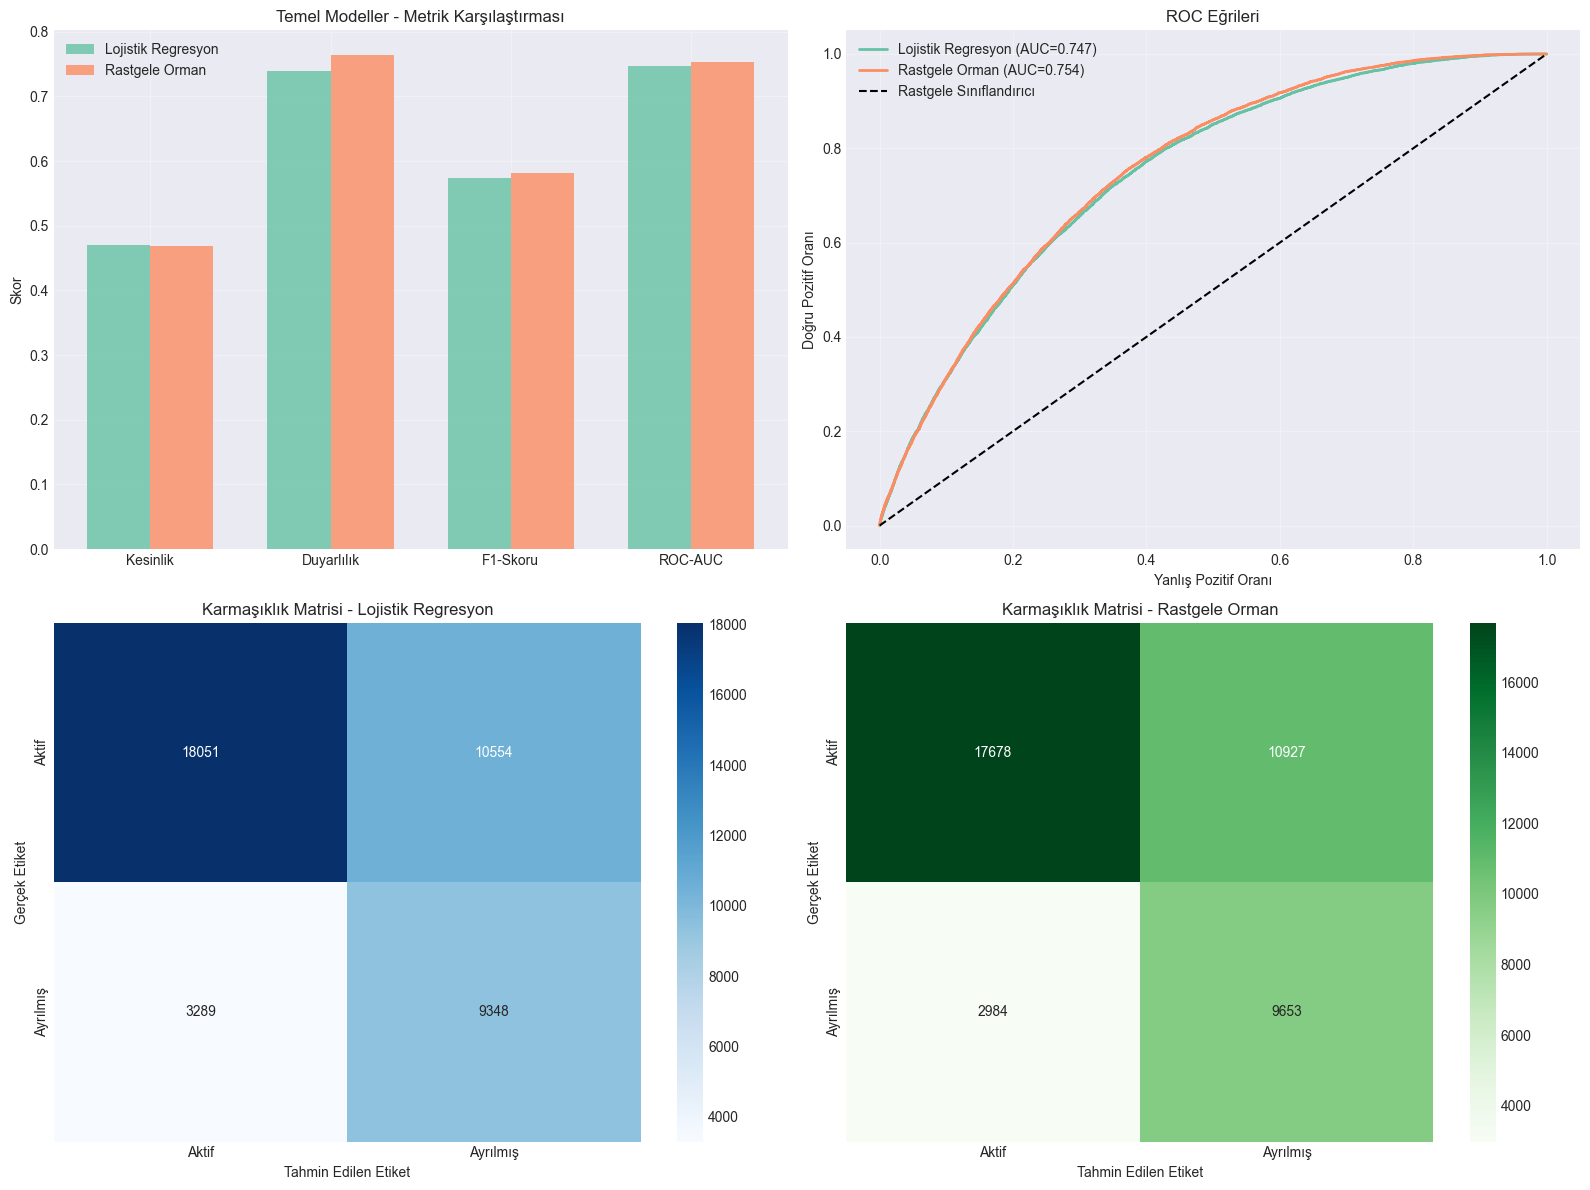

In [20]:
# Görselleştirmeler
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Metriklerin karşılaştırılması
ax = axes[0, 0]
metrics_to_plot = ['Kesinlik', 'Duyarlılık', 'F1-Skoru', 'ROC-AUC']
x = np.arange(len(metrics_to_plot))
width = 0.35

lr_values = [lr_metrics['precision'], lr_metrics['recall'], lr_metrics['f1'], lr_metrics['roc_auc']]
rf_values = [rf_metrics['precision'], rf_metrics['recall'], rf_metrics['f1'], rf_metrics['roc_auc']]

ax.bar(x - width/2, lr_values, width, label='Lojistik Regresyon', alpha=0.8)
ax.bar(x + width/2, rf_values, width, label='Rastgele Orman', alpha=0.8)
ax.set_ylabel('Skor')
ax.set_title('Temel Modeller - Metrik Karşılaştırması')
ax.set_xticks(x)
ax.set_xticklabels(metrics_to_plot)
ax.legend()
ax.grid(True, alpha=0.3)

# 2. ROC Eğrileri
ax = axes[0, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)

ax.plot(fpr_lr, tpr_lr, label=f'Lojistik Regresyon (AUC={lr_metrics["roc_auc"]:.3f})', linewidth=2)
ax.plot(fpr_rf, tpr_rf, label=f'Rastgele Orman (AUC={rf_metrics["roc_auc"]:.3f})', linewidth=2)
ax.plot([0, 1], [0, 1], 'k--', label='Rastgele Sınıflandırıcı')
ax.set_xlabel('Yanlış Pozitif Oranı')
ax.set_ylabel('Doğru Pozitif Oranı')
ax.set_title('ROC Eğrileri')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Karmaşıklık Matrisi - Lojistik Regresyon
ax = axes[1, 0]
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_title('Karmaşıklık Matrisi - Lojistik Regresyon')
ax.set_ylabel('Gerçek Etiket')
ax.set_xlabel('Tahmin Edilen Etiket')
ax.set_xticklabels(['Aktif', 'Ayrılmış'])
ax.set_yticklabels(['Aktif', 'Ayrılmış'])

# 4. Karmaşıklık Matrisi - Rastgele Orman
ax = axes[1, 1]
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=ax)
ax.set_title('Karmaşıklık Matrisi - Rastgele Orman')
ax.set_ylabel('Gerçek Etiket')
ax.set_xlabel('Tahmin Edilen Etiket')
ax.set_xticklabels(['Aktif', 'Ayrılmış'])
ax.set_yticklabels(['Aktif', 'Ayrılmış'])

plt.tight_layout()
plt.savefig('../plots/05_baseline_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

<h2>
    Grafik Yorumu: Temel Model Sonuçlarının Değerlendirilmesi ve Görselleştirilmesi
</h2>

<p>
    Bu bölümde, oluşturduğumuz iki temel modelin (<b>Lojistik Regresyon</b> ve <b>Rastgele Orman</b>) performansını karşılaştırmak ve derinlemesine analiz etmek için oluşturulan grafikleri inceliyoruz. Her bir grafik, model performansının farklı bir yönünü aydınlatmaktadır.
</p>

<hr>

<h3>
    1. Metrik Karşılaştırma Grafiği
</h3>
<p>
    İlk grafik, dört temel performans metriği üzerinden iki modelin doğrudan karşılaştırmasını sunar:
</p>
<ul>
    <li>
        <b>Kesinlik (Precision):</b> Modelin "Müşteri Terk Etti" olarak tahmin ettiği durumlardan ne kadarının gerçekten doğru olduğunu gösterir. Yüksek kesinlik, sadık müşterileri yanlışlıkla riskli olarak etiketleme (Yanlış Pozitif) maliyetinin yüksek olduğu senaryolarda önemlidir.
    </li>
    <li>
        <b>Duyarlılık (Recall):</b> Gerçekten terk eden müşterilerin ne kadarını modelin tespit edebildiğini ölçer. Yüksek duyarlılık, riskli bir müşteriyi kaçırma (Yanlış Negatif) maliyetinin yüksek olduğu durumlarda kritik öneme sahiptir.
    </li>
    <li>
        <b>F1-Skoru:</b> Kesinlik ve Duyarlılık metriklerinin harmonik ortalamasıdır. Bu iki metrik arasında bir denge kurar ve modelin genel doğruluğu hakkında dengeli bir fikir verir.
    </li>
    <li>
        <b>ROC-AUC:</b> Modelin pozitif ve negatif sınıfları (Terk Eden ve Aktif Müşteriler) ne kadar iyi ayırt edebildiğini gösteren bir ölçüttür. Değerin 1'e yakın olması, modelin ayırt etme gücünün yüksek olduğunu gösterir.
    </li>
</ul>
<p>
    Bu grafiğe göre, <b>Rastgele Orman</b> modelinin tüm metriklerde Lojistik Regresyon'a göre marjinal de olsa daha iyi bir performans sergilediği görülmektedir.
</p>

<h3>
    2. ROC Eğrileri
</h3>
<p>
    ROC (Receiver Operating Characteristic) eğrisi, modelin farklı eşik değerlerinde <b>Doğru Pozitif Oranı</b>'nı (Duyarlılık) <b>Yanlış Pozitif Oranı</b>'na karşı görselleştirir.
</p>
<ul>
    <li>
        Eğrinin sol üst köşeye ne kadar yakınsa, modelin performansı o kadar iyidir.
    </li>
    <li>
        Kesikli çizgi, tamamen rastgele tahmin yapan bir modeli (AUC = 0.5) temsil eder. Bizim modellerimiz bu çizgiden belirgin şekilde daha iyi performans göstermektedir.
    </li>
    <li>
        Parantez içindeki <b>AUC (Area Under Curve)</b> değeri, eğrinin altında kalan alanı ifade eder ve modelin genel sıralama yeteneğini tek bir sayı ile özetler. Rastgele Orman modelinin AUC değeri biraz daha yüksektir, bu da sınıfları ayırmada daha başarılı olduğunu teyit eder.
    </li>
</ul>


<h3>
    3. Karmaşıklık Matrisleri (Confusion Matrix)
</h3>
<p>
    Bu matrisler, modellerin tahminlerinin gerçek etiketlerle ne kadar örtüştüğünü detaylı bir şekilde gösterir. Her iki model için de matrisler şu şekilde okunabilir:
</p>
<ul>
    <li>
        <b>Sol Üst (Doğru Negatif):</b> Gerçekte "Aktif" olan ve model tarafından doğru şekilde "Aktif" olarak tahmin edilen müşteri sayısı.
    </li>
    <li>
        <b>Sağ Alt (Doğru Pozitif):</b> Gerçekte "Ayrılmış" olan ve model tarafından doğru şekilde "Ayrılmış" olarak tahmin edilen müşteri sayısı.
    </li>
    <li>
        <b>Sağ Üst (Yanlış Pozitif):</b> Gerçekte "Aktif" olan ancak model tarafından yanlışlıkla "Ayrılmış" olarak etiketlenen müşteri sayısı. <b>(Tip 1 Hata)</b>
    </li>
    <li>
        <b>Sol Alt (Yanlış Negatif):</b> Gerçekte "Ayrılmış" olan ancak model tarafından kaçırılıp "Aktif" olarak etiketlenen müşteri sayısı. <b>(Tip 2 Hata)</b>
    </li>
</ul>
<p>
    Her iki modelin de yüksek sayıda <b>Yanlış Pozitif</b> ürettiği dikkat çekmektedir. Bu, modellerin terk etme eğilimindeki müşterileri bulmada başarılı (yüksek Duyarlılık) olduğunu, ancak bunu yaparken birçok aktif müşteriyi de yanlışlıkla riskli olarak işaretlediğini (düşük Kesinlik) göstermektedir.
</p>

<hr>

<h4>
    Özet ve Sonraki Adımlar
</h4>
<p>
    Görselleştirmeler, her iki temel modelin de rastgele bir tahminden çok daha iyi olduğunu, ancak mükemmel olmaktan uzak olduğunu göstermektedir. Özellikle <b>Kesinlik (Precision) ve Duyarlılık (Recall) arasındaki denge</b>, iyileştirilmesi gereken en önemli alandır.
</p>
<p>
    Sonraki adımlar, bu Yanlış Pozitif sayısını azaltmaya odaklanmalı ve daha sofistike modeller (örn. XGBoost) veya daha gelişmiş özellik mühendisliği teknikleri kullanarak bu dengeyi optimize etmelidir.
</p>


En Önemli 20 Özellik (Rastgele Orman):


,feature,importance
3,avg_days_between_orders,0.220189
0,days_since_last_order,0.121395
2,customer_age_days,0.089675
5,orders_per_day,0.086844
4,total_orders,0.063195
7,std_days_between_orders,0.055087
9,total_items_ordered,0.039439
13,total_unique_products_ordered,0.038407
25,total_reordered_items,0.038349
29,favorite_products_count,0.035080


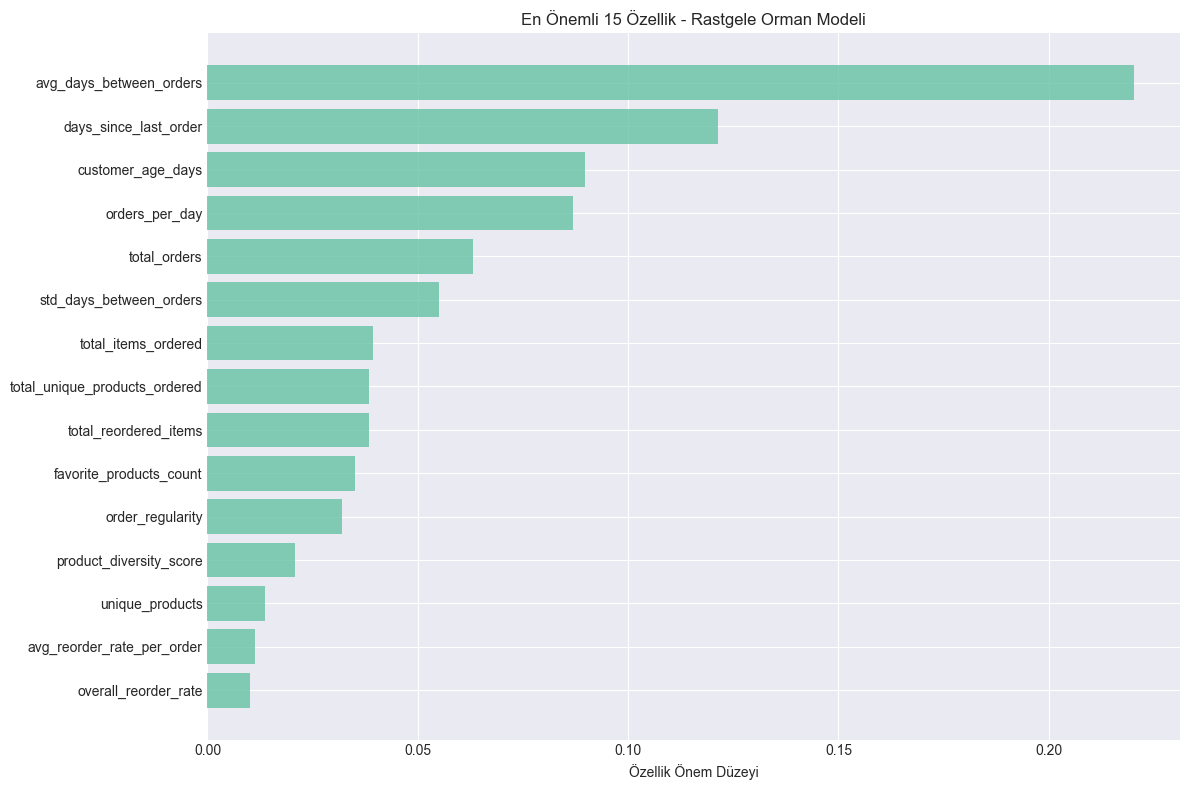

In [22]:
# Özellik Önem Düzeyleri (Rastgele Orman)
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nEn Önemli 20 Özellik (Rastgele Orman):")
display(feature_importance.head(20))

# En önemli 15 özelliği görselleştir
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'].values, alpha=0.8)
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Özellik Önem Düzeyi')
plt.title('En Önemli 15 Özellik - Rastgele Orman Modeli')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../plots/06_baseline_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

<h2>
    Grafik Yorumu: Modelin Karar Sürecini Anlamak: Özellik Önem Düzeyleri
</h2>

<p>
    Bir makine öğrenmesi modelinin sadece tahmin yapmakla kalmayıp, bu tahminleri hangi bilgilere dayanarak yaptığını anlamak da son derece önemlidir. <b>Özellik Önem Düzeyi</b> grafiği, Rastgele Orman modelimizin müşteri kaybını tahmin ederken hangi özellikleri "daha önemli" veya "daha belirleyici" bulduğunu bize gösterir. Grafikteki her çubuk, bir özelliğin modelin karar verme sürecine ne kadar katkıda bulunduğunu temsil eder; uzun çubuklar, daha yüksek etki anlamına gelir.
</p>

<hr>

<h3>
    Öne Çıkan En Önemli Özelliklerin Yorumlanması
</h3>

<p>
    Grafiği incelediğimizde, müşteri kaybı tahmini için en belirleyici olan özelliklerin, müşterinin <b>satın alma alışkanlıklarının zamanlaması ve sıklığı</b> ile ilgili olduğu açıkça görülmektedir.
</p>

<ol>
    <li>
        <b>avg_days_between_orders (Siparişler Arası Ortalama Gün):</b> Listenin başında yer alması, bir müşterinin satın alma ritminin en güçlü sinyal olduğunu gösteriyor. Bu değerin artmaya başlaması, müşterinin markadan uzaklaştığının ve "churn" riskinin arttığının en erken habercisi olabilir.
    </li>
    <li>
        <b>days_since_last_order (Son Siparişten Geçen Gün):</b> Bu, "Recency" (Yenilik) metriğinin doğrudan bir yansımasıdır. Bir müşterinin son siparişinin üzerinden ne kadar çok zaman geçerse, geri dönme olasılığı o kadar azalır. Modelimiz bu özelliği, kayıp müşterileri tespit etmek için kritik bir faktör olarak kullanmaktadır.
    </li>
    <li>
        <b>customer_age_days (Müşteri Yaşı - Gün):</b> Müşterinin platformdaki toplam süresini ifade eder. Bu özelliğin önemi, yeni müşteriler ile uzun süreli sadık müşterilerin farklı davranışlar sergilemesinden kaynaklanabilir. Yeni müşteriler daha değişken olabilirken, uzun süreli müşterilerin alışkanlıklarındaki bir değişiklik daha anlamlı bir sinyal olabilir.
    </li>
    <li>
        <b>orders_per_day (Gün Başına Sipariş) ve total_orders (Toplam Sipariş):</b> Bu iki metrik, müşterinin etkileşim sıklığını ve genel sadakatini ölçer. Yüksek sipariş sayısına sahip bir müşterinin aniden durması, önemli bir churn sinyalidir.
    </li>
</ol>

<h4>
    İş Stratejisi İçin Çıkarımlar
</h4>

<p>
    Bu özellik önem tablosu, müşteri kaybını önleme stratejileri için somut bir yol haritası sunar:
</p>
<ul>
    <li>
        <b>Proaktif Müdahale:</b> Müşterilerin <code>avg_days_between_orders</code> değerlerini sürekli olarak izleyerek, normal satın alma döngüsünün dışına çıkan müşterileri otomatik olarak tespit edebiliriz. Bu müşterilere, geri dönmelerini teşvik edecek kişiselleştirilmiş indirimler veya hatırlatma e-postaları gönderilebilir.
    </li>
    <li>
        <b>Segmentasyon:</b> <code>customer_age_days</code> özelliğini kullanarak "yeni", "gelişmekte olan" ve "sadık" müşteri segmentleri oluşturabiliriz. Her bir segmente yönelik farklı tutundurma kampanyaları (örneğin, yeni müşterilere hoş geldin serisi, sadık müşterilere özel VIP avantajları) tasarlanabilir.
    </li>
    <li>
        <b>Risk Skorlaması:</b> Bu önemli özellikleri kullanarak her müşteri için bir "churn riski skoru" oluşturulabilir. Pazarlama ve müşteri ilişkileri ekipleri, en yüksek risk skoruna sahip müşterilere odaklanarak kaynaklarını daha verimli kullanabilir.
    </li>
</ul>
<p>
    Sonuç olarak, modelimiz bize "kimin" terk edeceğini tahmin etmenin ötesinde, "neden" terk edebileceğine dair değerli ipuçları vermektedir. Bu da veri odaklı ve proaktif müşteri tutma stratejileri geliştirmemizi sağlar.
</p>

<h2>
    6-Temel Sonuçlar ve Sonraki Adımlar
</h2>

<h4>
    <b>Model Performansı</b>
</h4>

<p>
    Her iki temel model de dengesiz veri setinde (yaklaşık %30 churn oranı) eğitilmiştir. Modellerin performansını karşılaştırdığımızda aşağıdaki sonuçlar elde edilmiştir:
</p>

<ul>
    <li>
        <b>Lojistik Regresyon:</b>
        <ul>
            <li><b>ROC-AUC:</b> 0.7475</li>
            <li><b>F1-Skoru (Churn Sınıfı için):</b> 0.5746</li>
            <li>Basit, hızlı ve yorumlanabilir bir temel model olarak makul bir performans sergilemiştir. Özellikle "churn" edecek müşterileri yakalamada yüksek bir duyarlılığa (Recall: 0.74) sahiptir, ancak bu durum kesinliği (Precision: 0.47) düşürmüştür.</li>
        </ul>
    </li>
    <li>
        <b>Rastgele Orman (Random Forest):</b>
        <ul>
            <li><b>ROC-AUC:</b> 0.7536</li>
            <li><b>F1-Skoru (Churn Sınıfı için):</b> 0.5812</li>
            <li>Lojistik Regresyon'a göre hem F1-Skoru hem de ROC-AUC metriğinde çok az daha iyi bir performans göstermiştir. Duyarlılığı (Recall: 0.76) daha da yüksektir, bu da modeli churn eden müşterileri tespit etmede biraz daha başarılı kılar.</li>
        </ul>
    </li>
</ul>

<h4>
    <b>Temel Bulgular</b>
</h4>

<ul>
    <li>Her iki model de "churn" eden kullanıcıları hiç sipariş vermeyen kullanıcılardan ayırt etmede temel bir başarı göstermiştir.</li>
    <li>Modellerin duyarlılık (recall) metriklerinin kesinlikten (precision) daha yüksek olması, "churn" etme potansiyeli olan daha geniş bir kitleyi yakaladığını ancak bu tahminlerin bir kısmının yanlış pozitif olabileceğini göstermektedir. Bu durum, <code>class_weight='balanced'</code> parametresi kullanılmasının bir sonucudur.</li>
    <li>Rastgele Orman, Lojistik Regresyon'a göre bir miktar daha iyi olsa da, aradaki performans farkı çok azdır. Bu da daha gelişmiş özellik mühendisliği ve modelleme tekniklerinin churn tahmin doğruluğunu önemli ölçüde artırma potansiyeli taşıdığını göstermektedir.</li>
</ul>

<h4>
    <b>Sonraki Adımlar</b>
</h4>

<p>
    Bu temel modellerin performansı, daha ileri düzey çalışmalar için bir başlangıç noktası sunmaktadır. Potansiyel iyileştirme alanları şunlardır:
</p>

<ol>
    <li>
        <b>Özellik Mühendisliği</b>
        <ul>
            <li>RFM (Recency, Frequency, Monetary) skorları gibi daha karmaşık ve bütünsel müşteri metrikleri eklemek.</li>
            <li>Farklı özellikler arasında etkileşim özellikleri (ör. <code>ortalama sepet büyüklüğü * sipariş sıklığı</code>) oluşturmak.</li>
            <li>Zaman içindeki davranış değişimlerini yakalamak için zaman serisi özellikleri (ör. son 3 siparişteki ortalama harcama) türetmek.</li>
        </ul>
    </li>
    <li>
        <b>Gelişmiş Modeller</b>
        <ul>
            <li>Daha yüksek performans potansiyeli sunan <b>LightGBM</b>, <b>XGBoost</b> veya <b>CatBoost</b> gibi gradient boosting modellerini denemek.</li>
            <li>Farklı modellerin tahminlerini birleştiren topluluk (ensemble) yöntemleri uygulamak.</li>
        </ul>
    </li>
    <li>
        <b>Hiperparametre Optimizasyonu</b>
        <ul>
            <li>En iyi model parametrelerini bulmak için <b>Optuna</b> veya <b>GridSearchCV</b> gibi araçlarla hiperparametre optimizasyonu yapmak.</li>
            <li>Performansı artırmak ve aşırı öğrenmeyi (overfitting) önlemek için özellik seçimi (feature selection) algoritmaları kullanmak.</li>
        </ul>
    </li>
    <li>
        <b>Model Yorumlanabilirliği</b>
        <ul>
            <li>Modelin hangi özelliklere neden daha fazla önem verdiğini anlamak için <b>SHAP</b> veya <b>LIME</b> gibi kütüphanelerle analiz yapmak.</li>
            <li>Özelliklerin churn olasılığı üzerindeki etkisini görselleştirmek için kısmi bağımlılık grafikleri (Partial Dependence Plots) oluşturmak.</li>
        </ul>
    </li>
</ol>

<p>
    <b>Devam etmek için:</b> <code>03_feature_engineering.ipynb</code> not defterine geçin!
</p>

In [23]:
# Temel model sonuçlarını kaydet
baseline_results = {
    'logistic_regression': lr_metrics,
    'random_forest': rf_metrics,
    'feature_importance': feature_importance.to_dict(),
    'comparison': comparison_df.to_dict()
}

import json
with open('../docs/baseline_results.json', 'w') as f:
    json.dump(baseline_results, f, indent=4)

print("\nTemel model sonuçları docs/baseline_results.json dosyasına kaydedildi.")
print("\nTemel modelleme tamamlandı! Gelişmiş modellere geçmeye hazır.")


Temel model sonuçları docs/baseline_results.json dosyasına kaydedildi.

Temel modelleme tamamlandı! Gelişmiş modellere geçmeye hazır.
